Reference: https://wandb.ai/capecape/ddpm_clouds/reports/Diffusion-on-the-Clouds-Short-term-solar-energy-forecasting-with-Diffusion-Models--VmlldzozNDMxNTg5

### <span style="color:red">This notebook is written in special order, major framework (common for most models) first, then fill the details, whcih means the code on this page may not able run from top to bottom order</span>

# 1. Major Framework for a model

In [ ]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

In [ ]:
fashion=True
train_flag=True

In [ ]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [ ]:
if train_flag:
    training_loop(ddpm,loader,n_epochs,optim,device)

In [ ]:
best_model=MyDDPM(MyUNet(),n_step=n_steps,device=device) #network structure
best_model.load_state_dict(torch.load(store_path,map_location=device))
best_model.eval()
print('model loaded')

In [ ]:
generated = generated_new_images(
    best_model,
    n_samples = 100,
    device=device,
    gif_name = "fashion.gif" if fashion else "mnist.gif"
)
show_images(generated,"Final Result")

- Batch has 128 images
### the difference in training loop
- most are same as other models
- one different is `noisy_imgs = ddpm(x0,t,eta) #image at time t,  #128,1,28,28` the image can be calculated

In [ ]:
def training_loop(ddpm,loader,n_epotchs,optim,device,display=False,store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    
    for epotch in tqdm(range(n_epotchs), desc=f"Training Progress", color="#00ff00"):
        epoch_loss=0.0
        for step,batch in enumerate(tqdm(loader,leave=False, desc=f"Epoch {epotch+1}/{n_epochs}", color="#005500")):
            #loading data
            x0 = batch[0].to(device)
            
            n = len(x0) #batch size
            
            
            noisy_imgs = ddpm(x0,t,eta) #image at time t,  #128,1,28,28
            eta_theta = ddpm.backward(noisy_imgs,t) # the predicted noise at time t
            
            loss = mse(eta_theta, eta)  # compare predicted and original at time t
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_loss += loss.item()*len(x0)/len(loader.dataset)  #dynamic loss
            
        # display images generated at this epoch
        if display:
            show_images(generated_new_images(ddpm,device=device), f"images generated at epoch {epoch+1}")
            
        # prepare log string for printing
        log_string = f"Loss at epoch {epoch+1}: {epoch_loss:.3f}"
        
        #save model
        if best_loss >epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(),store_path)
            log_string += " ---> Best model ever stored"
        print(log_string)

# 2. Fill the details

### Class DDPM

- forward
- backward
- model - UNet

#### We create a fake UNet , output and input are linear (make it simple)


In [ ]:
import torch
import torch.nn as nn

class FakeUNet(nn.Module):
    def __init__(self):
        super(FakeUNet, self).__init__()
        self.linear = nn.Linear(28*28,28*28)
        
    def forward(self,x,t):
        x = x.view(x.size(0),-1) # flatten the input
        x = self.linear(x)
        return x.view(x.size(0),1,28,28) #reshapeback to original shape

#### Forward
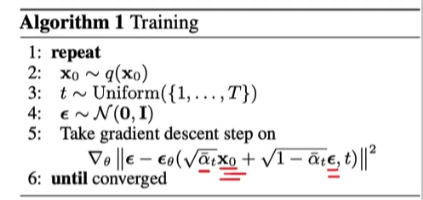

In [ ]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        # split n_steps sections from min to max
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)  # Number of steps is typically in the order of thousands
        
        self.alphas = 1 - self.betas
        
        
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)
        # in order to understand the above line, it can be written to 
        #alpha_bars_list=[]
        #for i in range(len(self.alphas)):
        #    alpha_bar_i = torch.prod(slef.alphas[:i+1])
        #    alpha_bars_list.append(alpha_bar_i)
        #self.alpha_bars = torch.tensor(alpha_bars_list).to(device)

        
    # this function is using to generate noise    
    def forward(self, x0, t, eta=None): #x0's batchsize = 128
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        
        return noisy #noise has same size as image

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [ ]:
if __name__ =='__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fake_unet = FakeUNet().to(device)
    
    ddpm = my DDPM(fake_unet,device=device)
    x0 = torch.randn((1,1,28,28)).to(device)
    t = torch.randn(0,ddpm.n_steps,(1,)).to(device)
    
    noisy_image = ddpm.forward(x0,t)
    print("Forward - noisy_image.shape: ", noisy_image.shape)
    
    predict_noise = ddpm.backward(noisy_image,t)
    print("Backward - predict_noise.shape: ", predict_noise.shape)

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [ ]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

## 2. Loading data

In [ ]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

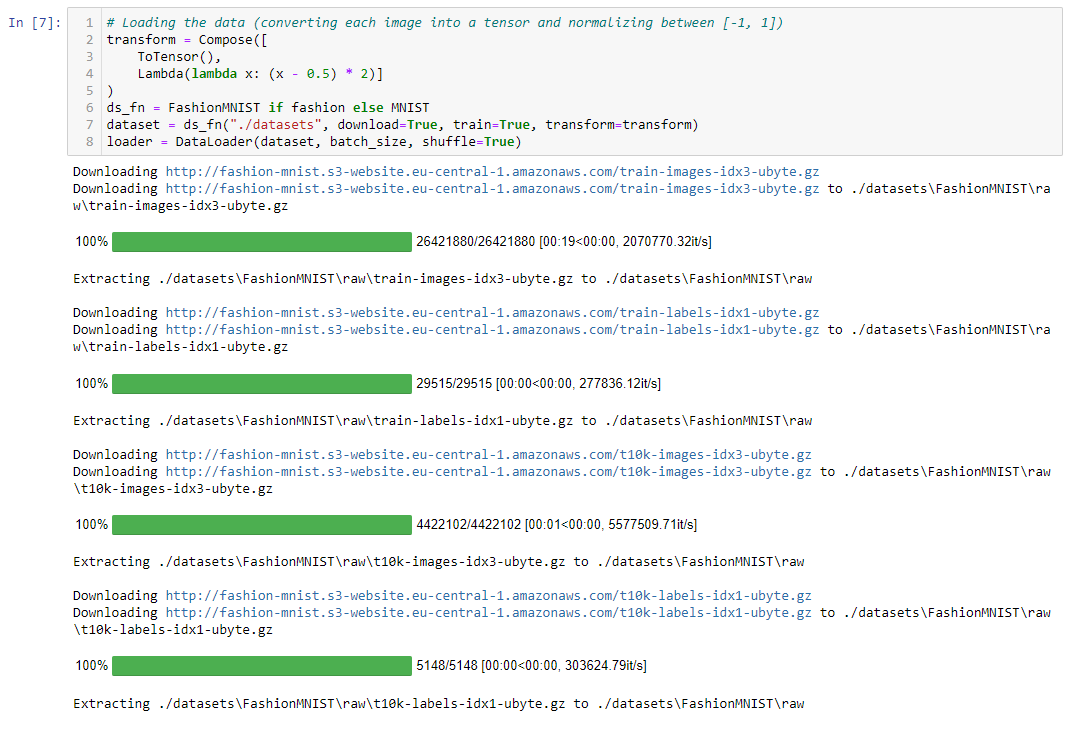

In [ ]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [ ]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

## 3. Defining the DDPM module

In [ ]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

### Visualizing forward and backward

In [ ]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [ ]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

## 4. UNet architecture

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

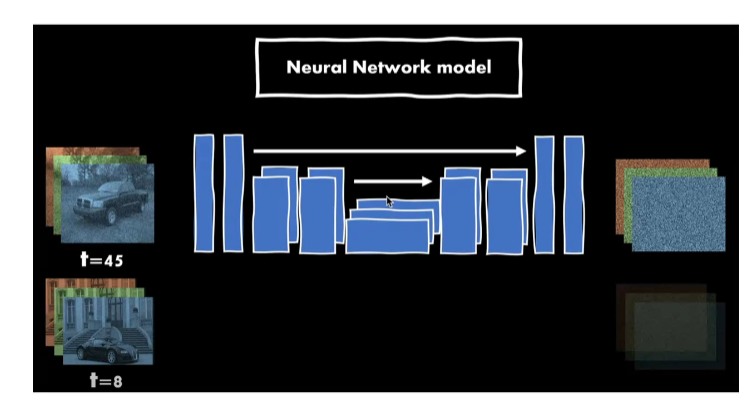
### UNet for Diffusion
- Traditional UNet doesn't know the difference between different frame (t)
- this is why current UNet need to add t as variable, so that it can recognize the position

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()
        
        ## Time Embedding
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim) 
        self.time_embed.requires_grad_(False)

        # First half =================================================
        ## Down Sampling 
        self.te1 = self._make_te(time_emb_dim, 1)  # te means time embedding, normal UNet doesn't have this
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)  # te means time embedding, normal UNet doesn't have this
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20) # te means time embedding, normal UNet doesn't have this
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck  =====================================================
        self.te_mid = self._make_te(time_emb_dim, 40) # te means time embedding, normal UNet doesn't have this
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half  =====================================================
        ## Up scale
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)  # te means time embedding, normal UNet doesn't have this
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)  # te means time embedding, normal UNet doesn't have this
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)  # te means time embedding, normal UNet doesn't have this
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7) #skip connection, add features from down sampling side

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14) #skip connection, add features from down sampling side

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28) #skip connection, add features from down sampling side

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

### Code and Structure
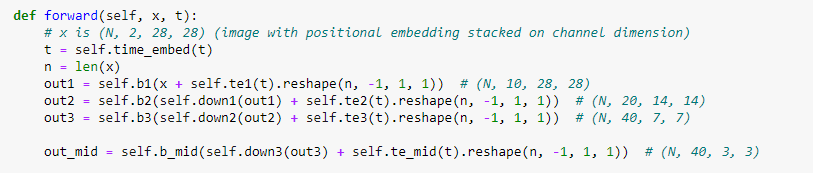
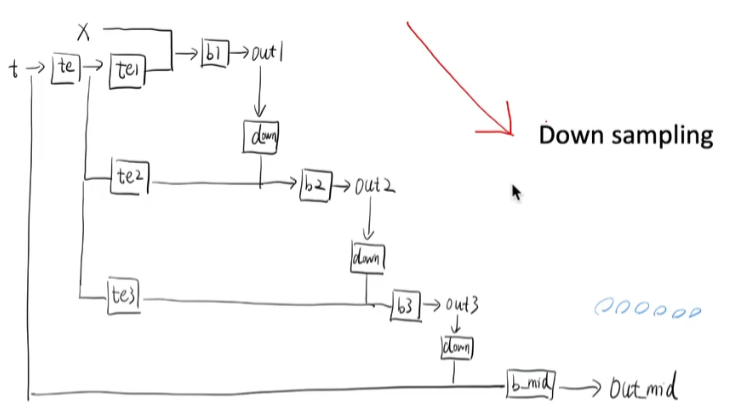

- #### te contains 2 linear layer
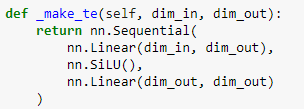



- #### Up scaling contains "Skip Connction" in Code
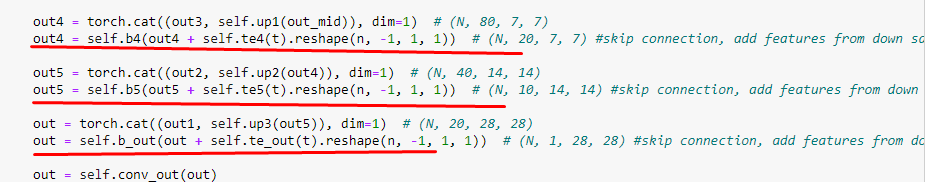
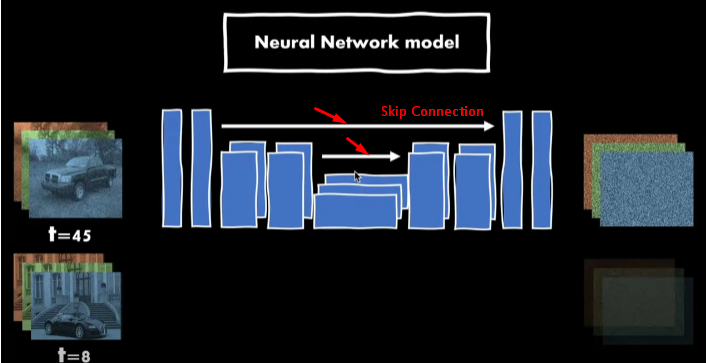

- #### Sinusoidal 位置编码
https://cloud.tencent.com/developer/article/1823505
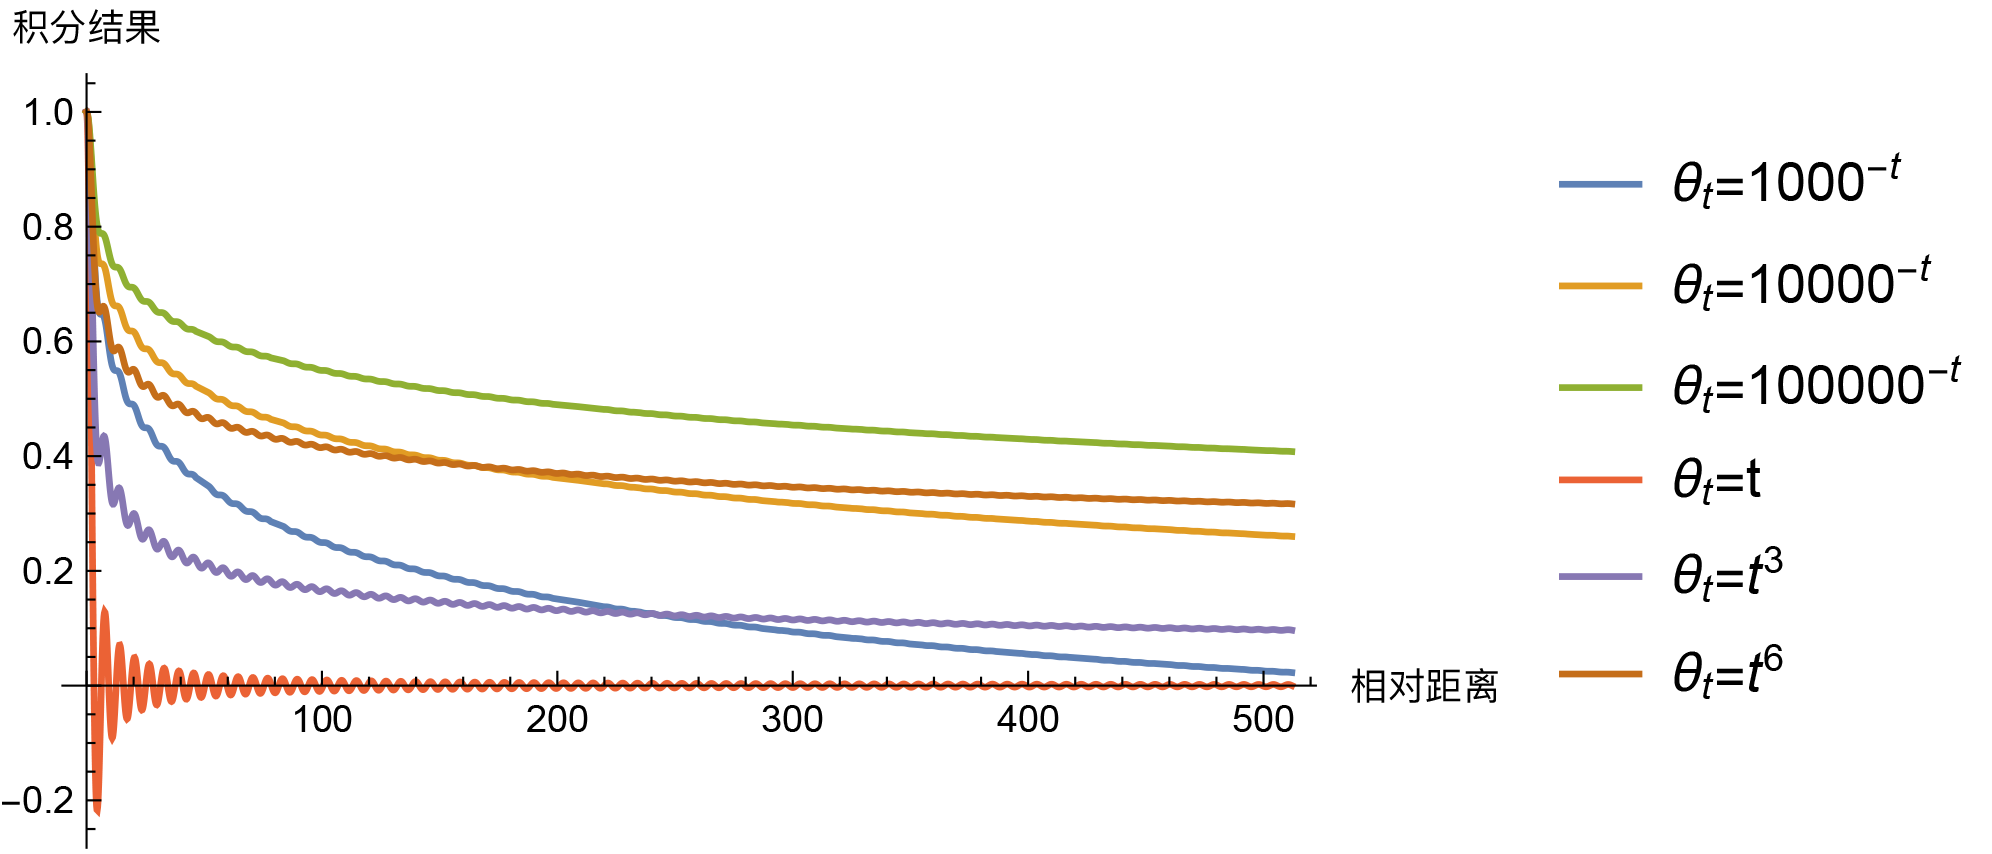